In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random, json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import numpy as np

""" LSTM Cell """
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        k = 1.0 / math.sqrt(hidden_size)
        self.W = nn.Parameter(torch.empty(input_size, 4 * hidden_size).uniform_(-k, k))
        self.U = nn.Parameter(torch.empty(hidden_size, 4 * hidden_size).uniform_(-k, k))
        self.b = nn.Parameter(torch.zeros(4 * hidden_size))

    def forward(self, x, h, c):
        gates = x @ self.W + h @ self.U + self.b
        i, f, g, o = gates.chunk(4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


""" Encoder-only Tagger """
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_tags, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_size)
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_tags)

    def forward(self, x):  # x: (batch, seq_len)
        batch_size, seq_len = x.size()
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(batch_size, self.hidden_size, device=x.device)

        outputs = []
        for t in range(seq_len):
            emb = self.embedding(x[:, t])
            h, c = self.lstm_cell(emb, h, c)
            logits = self.fc(h)              # (batch, num_tags)
            outputs.append(logits.unsqueeze(1))
        return torch.cat(outputs, dim=1)     # (batch, seq_len, num_tags)


""" Helper functions """
def build_vocab(data):
    word2idx, tag2idx = {"<PAD>":0}, {"<PAD>":0}
    for sent in data:
        for word, tag in sent:
            if word not in word2idx:
                word2idx[word] = len(word2idx)
            if tag not in tag2idx:
                tag2idx[tag] = len(tag2idx)
    idx2tag = {i:t for t,i in tag2idx.items()}
    return word2idx, tag2idx, idx2tag

def encode(data, word2idx, tag2idx, max_len=50):
    X, Y = [], []
    for sent in data:
        words = [word2idx.get(w,0) for w,t in sent][:max_len]
        tags = [tag2idx.get(t,0) for w,t in sent][:max_len]
        pad_len = max_len - len(words)
        words += [0]*pad_len
        tags  += [0]*pad_len
        X.append(words)
        Y.append(tags)
    return torch.tensor(X), torch.tensor(Y)


""" Training loop """
def train_tagger(model, train_X, train_Y, val_X, val_Y, num_tags, epochs=5, lr=0.001, batch_size=32, device="cuda"):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ckpt_path = "encoder_only.pt"

    for epoch in range(epochs):
        # ---------------- TRAIN ----------------
        model.train()
        indices = list(range(len(train_X)))
        random.shuffle(indices)
        total_loss = 0

        for i in tqdm(range(0, len(indices), batch_size), desc=f"Epoch {epoch}: "):
            batch_idx = indices[i:i+batch_size]
            Xb, Yb = train_X[batch_idx].to(device), train_Y[batch_idx].to(device)

            optimizer.zero_grad()
            outputs = model(Xb)  # (B, seq, num_tags)
            loss = criterion(outputs.view(-1, num_tags), Yb.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / math.ceil(len(indices) / batch_size)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(val_X), batch_size):
                Xb, Yb = val_X[i:i+batch_size].to(device), val_Y[i:i+batch_size].to(device)
                outputs = model(Xb)
                loss = criterion(outputs.view(-1, num_tags), Yb.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / math.ceil(len(val_X) / batch_size)

        # ---------------- LOGGING ----------------
        print(f"Epoch {epoch+1}/{epochs} "
              f"- Train Loss: {avg_train_loss:.4f} "
              f"- Val Loss: {avg_val_loss:.4f}")

        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved model checkpoint at epoch {epoch+1}")


""" Evaluation """
def evaluate_tagger(model, test_X, test_Y, idx2tag, batch_size=32, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(test_X), batch_size), desc="Evaluating"):
            Xb = test_X[i:i+batch_size].to(device)
            Yb = test_Y[i:i+batch_size].to(device)

            outputs = model(Xb)       # (B, seq, num_tags)
            preds = outputs.argmax(dim=-1)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(Yb.view(-1).cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    # Mask padding
    mask = all_labels != 0
    all_preds, all_labels = all_preds[mask], all_labels[mask]

    labels = list(range(1, len(idx2tag)))  
    target_names = [idx2tag[i] for i in labels]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=labels, target_names=target_names))

    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title("POS Tagging Confusion Matrix")
    plt.show()

Epoch 0: 100%|██████████| 1524/1524 [00:56<00:00, 27.02it/s]


Epoch 1/10 - Train Loss: 0.4435 - Val Loss: 0.2475
✅ Saved model checkpoint at epoch 1


Epoch 1: 100%|██████████| 1524/1524 [00:51<00:00, 29.66it/s]


Epoch 2/10 - Train Loss: 0.1681 - Val Loss: 0.1929
✅ Saved model checkpoint at epoch 2


Epoch 2: 100%|██████████| 1524/1524 [00:51<00:00, 29.42it/s]


Epoch 3/10 - Train Loss: 0.1113 - Val Loss: 0.1830
✅ Saved model checkpoint at epoch 3


Epoch 3: 100%|██████████| 1524/1524 [00:51<00:00, 29.50it/s]


Epoch 4/10 - Train Loss: 0.0813 - Val Loss: 0.1798
✅ Saved model checkpoint at epoch 4


Epoch 4: 100%|██████████| 1524/1524 [00:51<00:00, 29.57it/s]


Epoch 5/10 - Train Loss: 0.0613 - Val Loss: 0.1838
✅ Saved model checkpoint at epoch 5


Epoch 5: 100%|██████████| 1524/1524 [00:51<00:00, 29.55it/s]


Epoch 6/10 - Train Loss: 0.0476 - Val Loss: 0.1920
✅ Saved model checkpoint at epoch 6


Epoch 6: 100%|██████████| 1524/1524 [00:52<00:00, 28.88it/s]


Epoch 7/10 - Train Loss: 0.0375 - Val Loss: 0.2035
✅ Saved model checkpoint at epoch 7


Epoch 7: 100%|██████████| 1524/1524 [00:51<00:00, 29.47it/s]


Epoch 8/10 - Train Loss: 0.0300 - Val Loss: 0.2174
✅ Saved model checkpoint at epoch 8


Epoch 8: 100%|██████████| 1524/1524 [00:51<00:00, 29.32it/s]


Epoch 9/10 - Train Loss: 0.0239 - Val Loss: 0.2371
✅ Saved model checkpoint at epoch 9


Epoch 9: 100%|██████████| 1524/1524 [00:52<00:00, 29.13it/s]


Epoch 10/10 - Train Loss: 0.0190 - Val Loss: 0.2524
✅ Saved model checkpoint at epoch 10


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 97.78it/s] 



Classification Report:
              precision    recall  f1-score   support

         DET       0.98      0.98      0.98      5207
        NOUN       0.95      0.90      0.92      9174
         ADJ       0.82      0.88      0.85      2835
        VERB       0.94      0.97      0.95      8325
         ADP       0.93      0.93      0.93      4911
           .       1.00      1.00      1.00      7876
         ADV       0.89      0.88      0.88      2745
        CONJ       0.99      1.00      0.99      1638
         PRT       0.85      0.87      0.86      1727
        PRON       0.98      0.98      0.98      3496
         NUM       0.74      0.97      0.84       280
           X       0.54      0.14      0.22        99

    accuracy                           0.94     48313
   macro avg       0.88      0.87      0.87     48313
weighted avg       0.94      0.94      0.94     48313



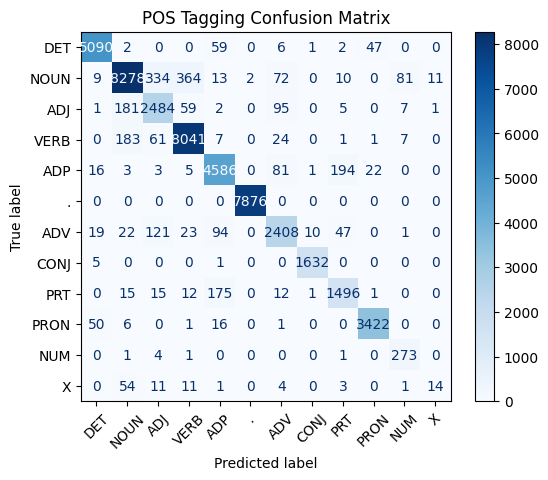

In [ ]:

""" ---------- Main Script ---------- """

with open("train-data.json") as f: train_data = json.load(f)
with open("val-data.json") as f: val_data = json.load(f)
with open("test-data.json") as f: test_data = json.load(f)

def convert_back(data):
    return [[(list(d.keys())[0], list(d.values())[0]) for d in sent] for sent in data]

train_data, val_data, test_data = map(convert_back, [train_data, val_data, test_data])

# Build vocab
word2idx, tag2idx, idx2tag = build_vocab(train_data + val_data + test_data)
vocab_size, num_tags = len(word2idx), len(tag2idx)

max_len = 50
train_X, train_Y = encode(train_data, word2idx, tag2idx, max_len)
val_X, val_Y     = encode(val_data, word2idx, tag2idx, max_len)
test_X, test_Y   = encode(test_data, word2idx, tag2idx, max_len)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMTagger(vocab_size, embedding_dim=128, hidden_size=128, num_tags=num_tags, pad_idx=0).to(device)

# Train
train_tagger(model, train_X, train_Y, val_X, val_Y, num_tags, epochs=10, device=device)

# Load best checkpoint
model.load_state_dict(torch.load("encoder_only.pt", map_location=device))

# Evaluate
evaluate_tagger(model, test_X, test_Y, idx2tag, batch_size=32, device=device)

In [6]:
def show_predictions(model, test_X, test_Y, idx2tag, word2idx, idx2word=None, batch_size=5, device="cuda"):
    model.eval()
    if idx2word is None:
        idx2word = {i:w for w,i in word2idx.items()}
    
    with torch.no_grad():
        Xb = test_X[:batch_size].to(device)
        Yb = test_Y[:batch_size].to(device)

        outputs = model(Xb)                 # (B, seq, num_tags)
        preds = outputs.argmax(dim=-1)      # (B, seq)

        for i in range(batch_size):
            words = [idx2word[x.item()] for x in Xb[i] if x.item() != 0]
            true_tags = [idx2tag[y.item()] for y in Yb[i] if y.item() != 0]
            pred_tags = [idx2tag[p.item()] for p, y in zip(preds[i], Yb[i]) if y.item() != 0]

            print(f"\nSentence {i+1}:")
            print("Words:     ", " ".join(words))
            print("True tags: ", " ".join(true_tags))
            print("Pred tags: ", " ".join(pred_tags))

with open("train-data.json") as f: train_data = json.load(f)
with open("val-data.json") as f: val_data = json.load(f)
with open("test-data.json") as f: test_data = json.load(f)

def convert_back(data):
    return [[(list(d.keys())[0], list(d.values())[0]) for d in sent] for sent in data]

train_data, val_data, test_data = map(convert_back, [train_data, val_data, test_data])

# Build vocab
word2idx, tag2idx, idx2tag = build_vocab(train_data + val_data + test_data)
vocab_size, num_tags = len(word2idx), len(tag2idx)

max_len = 50
train_X, train_Y = encode(train_data, word2idx, tag2idx, max_len)
val_X, val_Y     = encode(val_data, word2idx, tag2idx, max_len)
test_X, test_Y   = encode(test_data, word2idx, tag2idx, max_len)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMTagger(vocab_size, embedding_dim=128, hidden_size=128, num_tags=num_tags, pad_idx=0).to(device)

# Load best checkpoint
model.load_state_dict(torch.load("encoder_only.pt", map_location=device))

show_predictions(model, test_X, test_Y, idx2tag, word2idx, batch_size=5, device=device)


Sentence 1:
Words:      Well , now she can sleep in the street for all I care '' ! !
True tags:  PRT . ADV PRON VERB VERB ADP DET NOUN ADP PRT PRON VERB . . .
Pred tags:  PRT . ADV PRON VERB VERB ADP DET NOUN ADP PRT PRON VERB . . .

Sentence 2:
Words:      `` That isn't like you , Janice '' , Chris said uncomfortably .
True tags:  . DET VERB ADP PRON . NOUN . . NOUN VERB ADV .
Pred tags:  . DET VERB ADP PRON . NOUN . . VERB VERB ADV .

Sentence 3:
Words:      Then I felt uncomfortable , too .
True tags:  ADV PRON VERB ADJ . ADV .
Pred tags:  ADV PRON VERB ADJ . ADV .

Sentence 4:
Words:      I didn't want to be like that , mean and bitter .
True tags:  PRON VERB VERB PRT VERB ADP DET . ADJ CONJ ADJ .
Pred tags:  PRON VERB VERB PRT VERB ADP DET . ADJ CONJ ADJ .

Sentence 5:
Words:      But , darn it all , why should we help a couple of spoiled snobs who had looked down their noses at us ? ?
True tags:  CONJ . VERB PRON PRT . ADV VERB PRON VERB DET NOUN ADP VERB NOUN PRON VERB VERB ADP